In [ ]:
%pip install langchain_community
%pip install langchain_experimental
%pip install langchain-openai
%pip install langchainhub
%pip install chromadb
%pip install langchain
%pip install python-dotenv
%pip install rank_bm25
%pip install langchain_core

# new packages to download for this code lab!
%pip install "unstructured[pdf]"
%pip install pillow
%pip install pydantic
%pip install lxml
%pip install matplotlib
%pip install tiktoken
!sudo apt-get -y install poppler-utils
!sudo apt-get -y install tesseract-ocr

In [1]:
import os
import openai
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import chromadb
from langchain_community.vectorstores import Chroma
from dotenv import load_dotenv, find_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents.base import Document

# new
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain_core.runnables import RunnableLambda
from langchain.storage import InMemoryStore
from langchain_core.messages import HumanMessage
import base64
import uuid
from IPython.display import HTML, display
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
#### INDEXING ####

In [2]:
# If you cannot use .env, save the file as env and use this code to access:
_ = load_dotenv(dotenv_path='env.txt')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
openai.api_key = os.environ['OPENAI_API_KEY']
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)
embedding_function = OpenAIEmbeddings()
short_pdf_path = "google-2023-environmental-report-short.pdf"
user_query = "What are Google's environmental initiatives?"
str_output_parser = StrOutputParser()

In [3]:
# Extract elements from PDF using LangChain and Unstructured - can take a little time to load!
pdfloader = UnstructuredPDFLoader(
    short_pdf_path,
    mode="elements",
    strategy="hi_res",
    extract_image_block_types=["Image","Table"],
    extract_image_block_to_payload=True, # converts images to base64 format
)

pdf_data = pdfloader.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

In [4]:
texts = [doc for doc in pdf_data if doc.metadata["category"] == "NarrativeText"]
images = [doc for doc in pdf_data if doc.metadata["category"] == "Image"]

print(f"TOTAL DOCS USED BEFORE REDUCTION: texts: {len(texts)} images: {len(images)}")
categories = set(doc.metadata["category"] for doc in pdf_data)
print(f"CATEGORIES REPRESENTED: {categories}")

TOTAL DOCS USED BEFORE REDUCTION: texts: 78 images: 17
CATEGORIES REPRESENTED: {'Footer', 'NarrativeText', 'Table', 'ListItem', 'Header', 'FigureCaption', 'Title', 'UncategorizedText', 'Image'}


In [5]:
# cost savings: keep only the first 3 images to save compute costs for summarization
if len(images) > 3:
    images = images[:3]
print(f"total documents after reduction: texts: {len(texts)} images: {len(images)}")

total documents after reduction: texts: 78 images: 3


In [6]:
def apply_prompt(img_base64):
    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    return [HumanMessage(content=[
        {"type": "text", "text": prompt},
        {"type": "image_url","image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},},
    ])]

# Just using the existing text as text summaries to save money, but you can add summaries here too in more robust applications
text_summaries = [doc.page_content for doc in texts]

# Store base64 encoded images, image summaries
img_base64_list = []
image_summaries = []

# Apply to images
for img_doc in images:
    base64_image = img_doc.metadata["image_base64"]
    img_base64_list.append(base64_image)
    message = llm.invoke(apply_prompt(base64_image))
    image_summaries.append(message.content)

In [7]:
vectorstore = Chroma(
    collection_name="mm_rag_google_environmental",
    embedding_function=embedding_function
)

In [8]:
# mult-vector retriever - initialize the storage layer
store = InMemoryStore()
id_key = "doc_id"

# Create the multi-vector retriever
retriever_multi_vector = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Helper function to add documents to the vectorstore and docstore
def add_documents(retriever, doc_summaries, doc_contents):
    doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
    summary_docs = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(doc_summaries)
    ]
    content_docs = [
        Document(page_content=doc.page_content, metadata={id_key: doc_ids[i]})
        for i, doc in enumerate(doc_contents)
    ]
    retriever.vectorstore.add_documents(summary_docs)
    retriever.docstore.mset(list(zip(doc_ids, content_docs)))

# Add texts and images to vectorstore, vectorization is handled automatically
if text_summaries:
    add_documents(retriever_multi_vector, text_summaries, texts)
if image_summaries:
    add_documents(retriever_multi_vector, image_summaries, images)

In [ ]:
#### RETRIEVAL and GENERATION ####

In [11]:
# Split base64-encoded images and texts
def split_image_text_types(docs):
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document
        if isinstance(doc, Document):
            if doc.metadata.get("category") == "Image":
                base64_image = doc.metadata["image_base64"]
                b64_images.append(base64_image)
            else:
                texts.append(doc.page_content)
        else:
            # Handle the case when doc is a string
            if isinstance(doc, str):
                texts.append(doc)
    return {"images": b64_images, "texts": texts}

def img_prompt_func(data_dict):
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {"type": "image_url","image_url": {"url": f"data:image/jpeg;base64,{image}"}}
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are are a helpful assistant tasked with describing what is in an image.\n"
            "The user will ask for a picture of something.  Provide text that supports what was asked for.\n"
            "Use this information to provide an in-depth description of the aesthetics of the image. \n"
            "Be clear and concise and don't offer any additional commentary. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or images:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

In [12]:
# Create RAG chain
chain_multimodal_rag = (
        {"context": retriever_multi_vector | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
        | RunnableLambda(img_prompt_func)
        | llm
        | str_output_parser
    )

In [13]:
# Question - relevant question
user_query = "Picture of multiple wind turbines in the ocean."
chain_multimodal_rag.invoke(user_query)

'The image depicts a serene ocean scene with multiple wind turbines standing tall and gracefully in the water. The turbines are evenly spaced, their sleek, white blades contrasting against the deep blue of the ocean and the lighter blue of the sky. The horizon is clear, and the turbines stretch out into the distance, creating a sense of endless potential and tranquility. The overall aesthetic is one of modernity and sustainability, highlighting the harmony between advanced technology and the natural environment. The calm waters reflect the turbines, adding to the peaceful and clean energy theme of the image.'


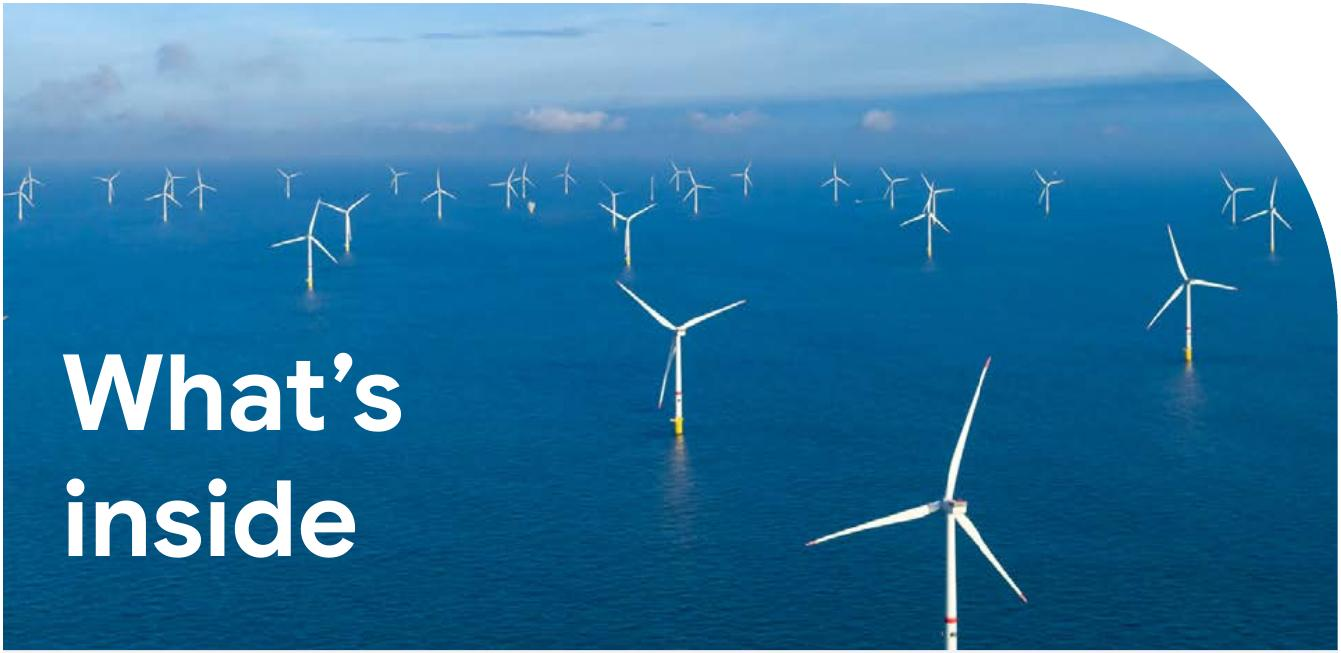

In [14]:
# Display a base64 image by rendering it with HTML
def plt_img_base64(img_base64):
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    display(HTML(image_html))

plt_img_base64(img_base64_list[1])

In [15]:
image_summaries[1] # matches index of the image.

'Offshore wind farm with multiple wind turbines in the ocean, text "What\'s inside" on the left side.'